# 本文件说明
- 聚类分析

# 基本设置

In [1]:
import jieba
from jieba import analyse
import sys
import re
import time
import string
from sklearn import feature_extraction
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif,f_classif 
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from collections import Counter

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Set2", 8)

import warnings
warnings.filterwarnings('ignore')

In [12]:
from toolkits.nlp.generate_keywords import generate_keywords
from toolkits.nlp import myclass_circ
from toolkits.nlp import myclass_cbrc
from toolkits.nlp import utils
from toolkits.setup.specific_func import set_ch_pd
set_ch_pd()

## 一些函数

# 导入数据

In [7]:
label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
class_name_dict = {v: k for k, v in label_dic.items()}

In [8]:
# from sklearn.externals import joblib
# pipeline_train = joblib.load( "model/circ_pipeline_20181108.pkl.z")
# X_features = joblib.load( "model/circ_features_20181108.pkl.z")
# label = joblib.load( "model/circ_labels_20181108.pkl.z")
# print(X_features.shape)
# print(len(label))

In [10]:
from sklearn.externals import joblib
pipeline_train = joblib.load( "model/previous_model/cbrc_pipeline_20181108.pkl.z")
X_features = joblib.load( "model/previous_model/cbrc_features_20181108.pkl.z")
label = joblib.load( "model/previous_model/cbrc_labels_20181108.pkl.z")
print(X_features.shape)
print(len(label))

(14192, 21180)
14192


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_features, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

X_train_dense = utils.DenseTransformer().fit_transform(X_train)
X_test_dense = utils.DenseTransformer().fit_transform(X_test)
print(X_test_dense.shape)

训练集： 9934
训练集-各类数量： Counter({8: 1924, 7: 1430, 2: 1252, 6: 1183, 1: 1133, 4: 1123, 5: 973, 3: 916})
测试集： 4258
测试集-各类数量： Counter({8: 797, 7: 600, 2: 534, 6: 527, 1: 507, 4: 456, 5: 442, 3: 395})
(4258, 21180)


# 聚类个数 k

## SSE选择k
- 手肘法的核心指标是SSE(sum of the squared errors，误差平方和)
> - 手肘法的核心思想是：随着聚类数k的增大，样本划分会更加精细，每个簇的聚合程度会逐渐提高，那么误差平方和SSE自然会逐渐变小。并且，当k小于真实聚类数时，由于k的增大会大幅增加每个簇的聚合程度，故SSE的下降幅度会很大，而当k到达真实聚类数时，再增加k所得到的聚合程度回报会迅速变小，所以SSE的下降幅度会骤减，然后随着k值的继续增大而趋于平缓，也就是说SSE和k的关系图是一个手肘的形状，而这个肘部对应的k值就是数据的真实聚类数。

In [7]:
from sklearn.cluster import MiniBatchKMeans

k_max = 30
SSE = []  # 存放每次结果的误差平方和
for k in range(1,k_max):
    print(k, '  -------------')
    estimator = MiniBatchKMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(X_features)
    SSE.append(estimator.inertia_)
print('SSE: ', SSE)

1   -------------
2   -------------
3   -------------
4   -------------
5   -------------
6   -------------
7   -------------
8   -------------
9   -------------
10   -------------
11   -------------
12   -------------
13   -------------
14   -------------
15   -------------
16   -------------
17   -------------
18   -------------
19   -------------
20   -------------
21   -------------
22   -------------
23   -------------
24   -------------
25   -------------
26   -------------
27   -------------
28   -------------
29   -------------
SSE:  [300743725.1549288, 300545134.1536706, 300712682.2299366, 300660190.8881691, 300586316.37852657, 300391072.77145994, 300448254.7768486, 300472756.5660409, 300347957.05482703, 300326154.47091496, 300438810.0821853, 300220521.14741296, 299981271.8131233, 300301840.0111316, 300245435.1743299, 300236386.1599827, 300175624.05211973, 300101220.91461897, 300143444.0514392, 300129432.3752903, 299888474.9207825, 300015064.3378631, 299937664.3292317, 2998724

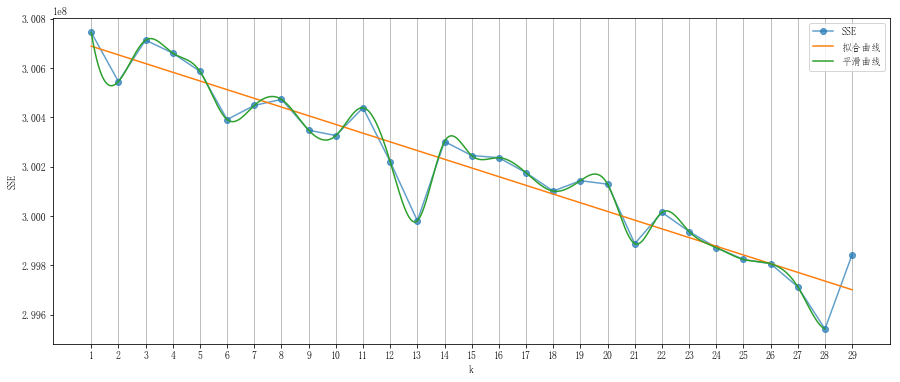

In [8]:
from scipy import interpolate

X = range(1,k_max)
Y = SSE

# 多项式拟合曲线
order = 1
c = np.polyfit(X,Y,order)#拟合多项式的系数存储在数组c中
y = np.polyval(c,X)#根据多项式求函数值

#插值法平滑处理后曲线
func = interpolate.interp1d(X, Y, kind='cubic')
xnew = np.arange(1,max(X)-1,0.01)
ynew = func(xnew)

plt.figure(num=None, figsize=(15, 6))
plt.plot(X,Y,'o-', alpha = 0.7)
plt.plot(X,y)
plt.plot(xnew,ynew)

plt.xticks(list(X))
plt.legend(['SSE', '拟合曲线', '平滑曲线'])
plt.xlabel('k')
plt.ylabel('SSE')

ax = plt.gca()
ax.xaxis.grid(True, which='major') #x坐标轴的网格使用主刻度

plt.show()

## 轮廓系数法
- 平均轮廓系数的取值范围为[-1,1]，且簇内样本的距离越近，簇间样本距离越远，平均轮廓系数越大，聚类效果越好。那么，很自然地，平均轮廓系数最大的k便是最佳聚类数。

In [ ]:
# from sklearn.cluster import MiniBatchKMeans
# from sklearn.metrics import silhouette_score

# Scores = []  # 存放轮廓系数
# for k in range(2,9):
#     print(k, '  -------------')
#     estimator = MiniBatchKMeans(n_clusters=k)  # 构造聚类器
#     estimator.fit(X_features)
#     Scores.append(silhouette_score(X_features, estimator.labels_,metric='euclidean'))
# print('Scores: ', Scores)

# plt.xlabel('k')
# plt.ylabel('轮廓系数')
# plt.plot(range(1,k_max), Scores, 'o-')
# plt.show()

2   -------------


## 总结

- k=2时轮廓系数最大，聚类效果应该非常好，那为什么SSE会这么大呢？
> - 原因在于轮廓系数考虑了分离度b，也就是样本与最近簇中所有样本的平均距离。为什么这么说，因为从定义上看，轮廓系数大，不一定是凝聚度a（样本与同簇的其他样本的平均距离）小，而可能是b和a都很大的情况下b相对a大得多，这么一来，a是有可能取得比较大的。a一大，样本与同簇的其他样本的平均距离就大，簇的紧凑程度就弱，那么簇内样本离质心的距离也大，从而导致SSE较大。所以，虽然轮廓系数引入了分离度b而限制了聚类划分的程度，但是同样会引来最优结果的SSE比较大的问题，这一点也是值得注意的。
> - 轮廓系数法确定出的最优k值不一定是最优的，有时候还需要根据SSE去辅助选取

# 基于距离的聚类算法

- CH越大代表着类自身越紧密，类与类之间越分散，即更优的聚类结果。

## K-means
- 事先确定聚类簇的个数

In [12]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=8)
t0 = time.time()
k_means.fit(X_train)
t1 = time.time()
k_means_pred = k_means.predict(X_test)
t2 = time.time()

print('训练耗时：%s s, 预测耗时：%s s'%(t1-t0, t2-t1))
print("CH指标: ", metrics.calinski_harabaz_score(X_test_dense, k_means_pred))
pd.DataFrame(k_means_pred)[0].value_counts()

训练耗时：191.1449327468872 s, 预测耗时：0.027001619338989258 s
CH指标:  5.605619643941353


2    3387
3     821
1      48
7       1
4       1
Name: 0, dtype: int64

## MiniBatchKMeans
- 事先确定聚类簇的个数
- 当样本量大于1万做聚类时，就需要考虑选用Mini Batch K-Means算法。但是，在选择算法时，除了算法效率（运行时间）外，算法运行的准确度也是选择算法的重要因素。
> - Mini Batch K-Means算法是K-Means算法的变种，采用小批量的数据子集减小计算时间，同时仍试图优化目标函数，这里所谓的小批量是指每次训练算法时所随机抽取的数据子集，采用这些随机产生的子集进行训练算法，大大减小了计算时间，与其他算法相比，减少了k-均值的收敛时间，小批量k-均值产生的结果，一般只略差于标准算法。

In [8]:
from sklearn.cluster import MiniBatchKMeans

mbk = MiniBatchKMeans(n_clusters=8)
t0 = time.time()
mbk.fit(X_train_dense)
t1 = time.time()
mbk_pred = mbk.predict(X_test_dense)
t2 = time.time()

print('训练耗时：%s s, 预测耗时：%s s'%(t1-t0, t2-t1))
print("CH指标: ", metrics.calinski_harabaz_score(X_test_dense, mbk_pred))
pd.DataFrame(mbk_pred)[0].value_counts()

训练耗时：3.2861881256103516 s, 预测耗时：0.48602771759033203 s
CH指标:  1.0061113416595662


5    4256
2       2
Name: 0, dtype: int64

## K-medoids
- 事先确定聚类簇的个数

## Mean-Shift
- 自动确定k的个数

In [ ]:
from sklearn.cluster import MeanShift

m_shift = MeanShift()
t0 = time.time()
m_shift.fit(X_train_dense)
t1 = time.time()
m_shift_pred = m_shift.predict(X_test_dense)
t2 = time.time()

print('训练耗时：%s s, 预测耗时：%s s'%(t1-t0, t2-t1))
print("CH指标: ", metrics.calinski_harabaz_score(X_test_dense, m_shift_pred))
pd.DataFrame(m_shift_pred)[0].value_counts()

# 基于密度的聚类算法

## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = SpectralClustering(n_clusters=8)
t0 = time.time()
dbscan.fit(X_train_dense)
t1 = time.time()
dbscan_pred = dbscan.predict(X_test_dense)
t2 = time.time()

print('训练耗时：%s s, 预测耗时：%s s'%(t1-t0, t2-t1))
print("CH指标: ", metrics.calinski_harabaz_score(X_test_dense, dbscan_pred))
pd.DataFrame(dbscan_pred)[0].value_counts()

# 基于图论的谱聚类算法

In [ ]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=8)
t0 = time.time()
sc.fit(X_train_dense)
t1 = time.time()
sc_pred = sc.predict(X_test_dense)
t2 = time.time()

print('训练耗时：%s s, 预测耗时：%s s'%(t1-t0, t2-t1))
print("CH指标: ", metrics.calinski_harabaz_score(X_test_dense, sc_pred))
pd.DataFrame(sc_pred)[0].value_counts()

# 层次聚类

## BIRCH(平均迭代规约和聚类)
- 调参：类别数K、threshold和branching_factor。默认的threshold值0.5和默认的branching_factor值50.

In [13]:
from sklearn.cluster import Birch

birch = Birch(n_clusters=8)
t0 = time.time()
birch.fit(X_train_dense)
t1 = time.time()
birch_pred = birch.predict(X_test_dense)
t2 = time.time()

print('训练耗时：%s s, 预测耗时：%s s'%(t1-t0, t2-t1))
print("CH指标: ", metrics.calinski_harabaz_score(X_test_dense, birch_pred))
pd.DataFrame(birch_pred)[0].value_counts()

MemoryError: 

In [ ]:
# 尝试多个threshold取值，和多个branching_factor取值
param_grid = {'threshold':[0.5,0.3,0.1],'branching_factor':[50,20,10]}
for threshold in param_grid['threshold']:
    for branching_factor in param_grid['branching_factor']:
        clf = Birch(n_clusters = 4,threshold=threshold,branching_factor=branching_factor)
        clf.fit(X)
        y_pred = clf.predict(X)
        print(threshold,branching_factor,"CH指标:", metrics.calinski_harabaz_score(X, y_pred))


## AG算法

In [9]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=8)
t0 = time.time()
agg.fit(X_train_dense)
t1 = time.time()
agg_pred = agg.predict(X_test_dense)
t2 = time.time()

print('训练耗时：%s s, 预测耗时：%s s'%(t1-t0, t2-t1))
print("CH指标: ", metrics.calinski_harabaz_score(X_test_dense, agg_pred))
pd.DataFrame(agg_pred)[0].value_counts()

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

# 聚类结果评价
- 基于距离的聚类算法是以数据点为单位进行研究，基于密度的聚类算法则从点转化为面，基于图论的谱聚类算法则通过数据降维 高算法效率。